In [143]:
from pathlib import Path
import uproot

# --- Paths ---
# Jupyter sometimes starts in your home directory, so we anchor to the known workspace folder first.
WORKSPACE_DIR = Path(r"D:\Particle collision event classification")
DATA_DIR = WORKSPACE_DIR / "Data" if (WORKSPACE_DIR / "Data").exists() else (Path.cwd() / "Data")
print("Using DATA_DIR:", DATA_DIR)

sig_path = DATA_DIR / "ODEO_FEB2025_v0_2J2LMET30_mc_301333.Pythia8EvtGen_A14NNPDF23LO_zprime3000_tt.2J2LMET30.root"
bg_path  = DATA_DIR / "ODEO_FEB2025_v0_2J2LMET30_mc_410081.MadGraphPythia8EvtGen_A14NNPDF23_ttbarWW.2J2LMET30.root"

for p in (sig_path, bg_path):
    assert p.exists(), f"Missing file: {p}"

# Open SIGNAL (Z' -> t tbar)
file = uproot.open(sig_path)
file

Using DATA_DIR: D:\Particle collision event classification\Data


<ReadOnlyDirectory '/' at 0x02a9e7a67020>

In [144]:
# Ensure required packages are available in THIS notebook kernel
import sys
import subprocess

def ensure_import(pkg_name, pip_name=None):
    try:
        __import__(pkg_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg_name])
        __import__(pkg_name)

ensure_import("uproot")
ensure_import("awkward")
ensure_import("sklearn", "scikit-learn")
ensure_import("xgboost")
ensure_import("vector")

import xgboost
print("Python:", sys.executable)
print("xgboost:", xgboost.__version__)

Python: C:\Users\arnab\anaconda3\python.exe
xgboost: 3.1.2


In [145]:
file.keys()


['analysis;1']

In [146]:
tree = file["analysis"]
tree

<TTree 'analysis' (118 branches) at 0x02a9e67a2ba0>

In [147]:
tree.keys()

['sig_lep',
 'n_sig_lep',
 'num_events',
 'sum_of_weights',
 'sum_of_weights_squared',
 'xsec',
 'kfac',
 'filteff',
 'TriggerMatch_DILEPTON',
 'ScaleFactor_MLTRIGGER',
 'ScaleFactor_PILEUP',
 'ScaleFactor_FTAG',
 'mcWeight',
 'channelNumber',
 'eventNumber',
 'runNumber',
 'trigML',
 'trigP',
 'trigDT',
 'trigT',
 'trigE',
 'trigDM',
 'trigDE',
 'trigM',
 'trigMET',
 'ScaleFactor_BTAG',
 'ScaleFactor_JVT',
 'jet_n',
 'jet_pt',
 'jet_eta',
 'jet_phi',
 'jet_e',
 'jet_btag_quantile',
 'jet_jvt',
 'largeRJet_n',
 'largeRJet_pt',
 'largeRJet_eta',
 'largeRJet_phi',
 'largeRJet_e',
 'largeRJet_m',
 'largeRJet_D2',
 'jet_pt_jer1',
 'jet_pt_jer2',
 'ScaleFactor_ELE',
 'ScaleFactor_MUON',
 'ScaleFactor_LepTRIGGER',
 'ScaleFactor_MuTRIGGER',
 'ScaleFactor_ElTRIGGER',
 'lep_n',
 'lep_type',
 'lep_pt',
 'lep_eta',
 'lep_phi',
 'lep_e',
 'lep_charge',
 'lep_ptvarcone30',
 'lep_topoetcone20',
 'lep_z0',
 'lep_d0',
 'lep_d0sig',
 'lep_isTightID',
 'lep_isMediumID',
 'lep_isLooseID',
 'lep_isTightIs

In [148]:
tree.num_entries

365

In [149]:
# Step 1: Select safe, flat event-level features

import pandas as pd

event_features = [
    "met",
    "met_phi",
    "jet_n",
    "lep_n",
    "n_sig_lep"
]

X_event = tree.arrays(event_features, library="pd")

X_event.head()


,met,met_phi,jet_n,lep_n,n_sig_lep
0,199.901657,0.438272,4,2,2
1,409.659424,1.717278,2,2,2
2,50.016842,-0.627112,3,3,2
3,572.252502,-2.895018,2,2,2
4,166.227509,3.093280,3,2,2


In [150]:
import awkward as ak
import numpy as np

# Load jet-level jagged data (include phi so we can build physics features later)
jets = tree.arrays(
    ["jet_pt", "jet_eta", "jet_phi", "jet_btag_quantile"],
    library="ak"
)

# Leading / subleading jets (handle events with <2 jets)
jet_pt_padded = ak.pad_none(jets["jet_pt"], 2)
jet_eta_padded = ak.pad_none(jets["jet_eta"], 2)
jet_phi_padded = ak.pad_none(jets["jet_phi"], 2)

lead_jet_pt  = ak.fill_none(jet_pt_padded[:, 0], 0)
lead_jet_eta = ak.fill_none(jet_eta_padded[:, 0], 0)
lead_jet_phi = ak.fill_none(jet_phi_padded[:, 0], 0)
lead_jet_btag = ak.fill_none(ak.firsts(jets["jet_btag_quantile"]), -1)

sublead_jet_pt  = ak.fill_none(jet_pt_padded[:, 1], 0)
sublead_jet_eta = ak.fill_none(jet_eta_padded[:, 1], 0)
sublead_jet_phi = ak.fill_none(jet_phi_padded[:, 1], 0)

# Scalar HT = sum of jet pT
ht = ak.sum(jets["jet_pt"], axis=1)

# Add to dataframe
X_event["lead_jet_pt"] = np.array(lead_jet_pt)
X_event["lead_jet_eta"] = np.array(lead_jet_eta)
X_event["lead_jet_phi"] = np.array(lead_jet_phi)
X_event["lead_jet_btag"] = np.array(lead_jet_btag)
X_event["sublead_jet_pt"] = np.array(sublead_jet_pt)
X_event["sublead_jet_eta"] = np.array(sublead_jet_eta)
X_event["sublead_jet_phi"] = np.array(sublead_jet_phi)
X_event["ht"] = np.array(ht)

X_event.head()

,met,met_phi,jet_n,lep_n,n_sig_lep,lead_jet_pt,lead_jet_eta,lead_jet_phi,lead_jet_btag,sublead_jet_pt,sublead_jet_eta,sublead_jet_phi,ht
0,199.901657,0.438272,4,2,2,67.861450,-1.586662,-2.269888,1,52.867718,1.422446,-1.552272,179.368454
1,409.659424,1.717278,2,2,2,555.775146,0.244203,1.132176,5,133.503601,1.921209,2.292408,689.278748
2,50.016842,-0.627112,3,3,2,155.632599,0.057262,0.571849,5,88.164810,1.041984,2.081995,267.055328
3,572.252502,-2.895018,2,2,2,461.594086,-0.002656,-2.697254,5,20.800121,1.698945,-2.858332,482.394196
4,166.227509,3.093280,3,2,2,180.990204,-0.757003,2.699011,5,71.000671,1.284215,1.714796,275.259918


In [151]:
# Load lepton-level jagged data
leps = tree.arrays(
    ["lep_pt", "lep_eta", "lep_phi", "lep_charge"],
    library="ak"
)

def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return np.arctan2(np.sin(dphi), np.cos(dphi))

def mll_massless(pt1, eta1, phi1, pt2, eta2, phi2):
    # massless approximation: E = p = pt*cosh(eta)
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    E1  = pt1 * np.cosh(eta1)
    px2 = pt2 * np.cos(phi2)
    py2 = pt2 * np.sin(phi2)
    pz2 = pt2 * np.sinh(eta2)
    E2  = pt2 * np.cosh(eta2)
    E = E1 + E2
    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2
    m2 = E*E - (px*px + py*py + pz*pz)
    return np.sqrt(np.maximum(m2, 0.0))

# Leading / subleading leptons (handle events with <2 leptons)
lep_pt_padded = ak.pad_none(leps["lep_pt"], 2)
lep_eta_padded = ak.pad_none(leps["lep_eta"], 2)
lep_phi_padded = ak.pad_none(leps["lep_phi"], 2)
lep_q_padded = ak.pad_none(leps["lep_charge"], 2)

lead_lep_pt = ak.fill_none(lep_pt_padded[:, 0], 0)
lead_lep_eta = ak.fill_none(lep_eta_padded[:, 0], 0)
lead_lep_phi = ak.fill_none(lep_phi_padded[:, 0], 0)
lead_lep_charge = ak.fill_none(lep_q_padded[:, 0], 0)

sublead_lep_pt = ak.fill_none(lep_pt_padded[:, 1], 0)
sublead_lep_eta = ak.fill_none(lep_eta_padded[:, 1], 0)
sublead_lep_phi = ak.fill_none(lep_phi_padded[:, 1], 0)
sublead_lep_charge = ak.fill_none(lep_q_padded[:, 1], 0)

# Dilepton physics features
m_ll = mll_massless(
    np.array(lead_lep_pt), np.array(lead_lep_eta), np.array(lead_lep_phi),
    np.array(sublead_lep_pt), np.array(sublead_lep_eta), np.array(sublead_lep_phi),
)
dphi_ll = np.abs(delta_phi(np.array(lead_lep_phi), np.array(sublead_lep_phi)))

# Total lepton pT sum and ST = HT + sum(lepton pT) + MET
lt = ak.sum(leps["lep_pt"], axis=1)
st = np.array(X_event["ht"]) + np.array(lt) + np.array(X_event["met"])

# Add to dataframe
X_event["lead_lep_pt"] = np.array(lead_lep_pt)
X_event["lead_lep_eta"] = np.array(lead_lep_eta)
X_event["lead_lep_phi"] = np.array(lead_lep_phi)
X_event["lead_lep_charge"] = np.array(lead_lep_charge)
X_event["sublead_lep_pt"] = np.array(sublead_lep_pt)
X_event["sublead_lep_eta"] = np.array(sublead_lep_eta)
X_event["sublead_lep_phi"] = np.array(sublead_lep_phi)
X_event["sublead_lep_charge"] = np.array(sublead_lep_charge)
X_event["m_ll"] = m_ll
X_event["dphi_ll"] = dphi_ll
X_event["lt"] = np.array(lt)
X_event["st"] = st

X_event.head()

,met,met_phi,jet_n,lep_n,n_sig_lep,lead_jet_pt,lead_jet_eta,lead_jet_phi,lead_jet_btag,sublead_jet_pt,...,lead_lep_phi,lead_lep_charge,sublead_lep_pt,sublead_lep_eta,sublead_lep_phi,sublead_lep_charge,m_ll,dphi_ll,lt,st
0,199.901657,0.438272,4,2,2,67.861450,-1.586662,-2.269888,1,52.867718,...,1.467015,-1,75.785873,0.449177,1.488404,1,178.815720,0.021389,775.954834,1155.224976
1,409.659424,1.717278,2,2,2,555.775146,0.244203,1.132176,5,133.503601,...,0.863450,1,37.807961,0.360418,0.521871,-1,40.498170,0.341579,70.008018,1168.946167
2,50.016842,-0.627112,3,3,2,155.632599,0.057262,0.571849,5,88.164810,...,-0.027653,-1,117.538589,-1.691479,-2.531035,1,476.933422,2.503381,406.943359,724.015503
3,572.252502,-2.895018,2,2,2,461.594086,-0.002656,-2.697254,5,20.800121,...,0.278764,1,44.451340,0.461074,3.026339,-1,379.791540,2.747575,397.886841,1452.533447
4,166.227509,3.093280,3,2,2,180.990204,-0.757003,2.699011,5,71.000671,...,-2.988659,-1,368.809296,1.967788,-0.462436,1,725.051464,2.526223,448.063293,889.550781


### Physics Interpretation
- **Signal hypothesis:** a heavy Z′ decaying to $t\bar{t}$ tends to produce **high-activity events** (large $H_T$ / $S_T$ and energetic objects).
- **Training setup:** simulation **Z′→$t\bar{t}$** (signal) vs **SM-like** sample (background).
- **Classifier output:** we later select “signal-like” events using a tight threshold such as **$P(\mathrm{signal}) > 0.9$** to reduce background contamination before making physics plots.

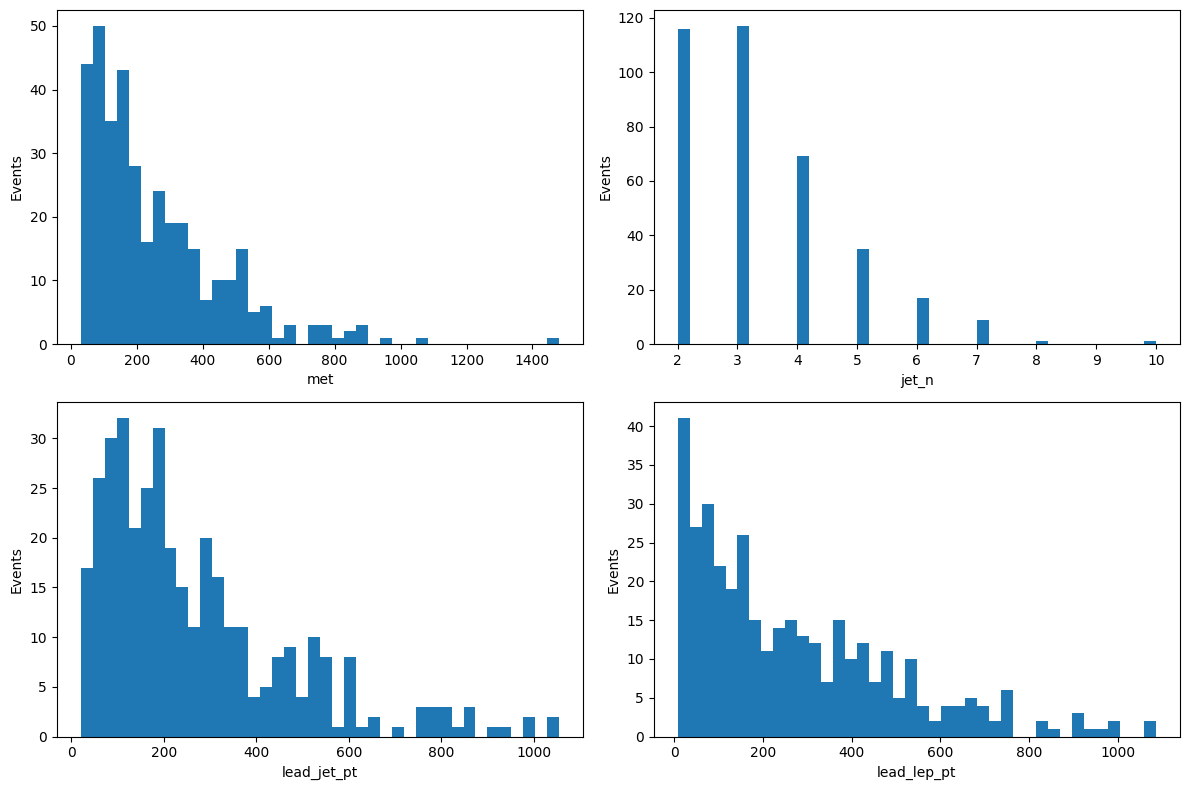

In [152]:
import matplotlib.pyplot as plt

features_to_plot = [
    "met",
    "jet_n",
    "lead_jet_pt",
    "lead_lep_pt"
]

plt.figure(figsize=(12, 8))

for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.hist(X_event[feat], bins=40)
    plt.xlabel(feat)
    plt.ylabel("Events")

plt.tight_layout()
plt.show()


In [153]:
# Labels
# y = 1  -> Signal (Z' -> t tbar)
# y = 0  -> Background (Standard Model-like sample)
import numpy as np

y = np.ones(len(X_event), dtype=int)

y[:10], len(y)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 365)

In [154]:
import uproot

# Open BACKGROUND
bg_file = uproot.open(bg_path)
bg_file

<ReadOnlyDirectory '/' at 0x02a9d6ec31d0>

In [155]:
bg_file.keys()


['analysis;1']

In [156]:
bg_tree = bg_file["analysis"]

bg_tree.num_entries


3404

In [157]:
# Event-level features (same as signal)

bg_event_features = [
    "met",
    "met_phi",
    "jet_n",
    "lep_n",
    "n_sig_lep"
]

X_bg = bg_tree.arrays(bg_event_features, library="pd")

X_bg.head()


,met,met_phi,jet_n,lep_n,n_sig_lep
0,30.263149,-0.447077,5,2,2
1,153.774963,-2.988026,4,3,2
2,59.318420,2.051819,5,2,2
3,176.947281,1.466450,4,2,2
4,269.332581,-0.148690,3,2,2


In [158]:
# Jet-level background features (include phi so we can build physics features later)

bg_jets = bg_tree.arrays(
    ["jet_pt", "jet_eta", "jet_phi", "jet_btag_quantile"],
    library="ak"
)

# Leading / subleading jets (handle events with <2 jets)
bg_jet_pt_padded = ak.pad_none(bg_jets["jet_pt"], 2)
bg_jet_eta_padded = ak.pad_none(bg_jets["jet_eta"], 2)
bg_jet_phi_padded = ak.pad_none(bg_jets["jet_phi"], 2)

bg_lead_jet_pt  = ak.fill_none(bg_jet_pt_padded[:, 0], 0)
bg_lead_jet_eta = ak.fill_none(bg_jet_eta_padded[:, 0], 0)
bg_lead_jet_phi = ak.fill_none(bg_jet_phi_padded[:, 0], 0)
bg_lead_jet_btag = ak.fill_none(ak.firsts(bg_jets["jet_btag_quantile"]), -1)

bg_sublead_jet_pt  = ak.fill_none(bg_jet_pt_padded[:, 1], 0)
bg_sublead_jet_eta = ak.fill_none(bg_jet_eta_padded[:, 1], 0)
bg_sublead_jet_phi = ak.fill_none(bg_jet_phi_padded[:, 1], 0)

# Scalar HT = sum of jet pT
bg_ht = ak.sum(bg_jets["jet_pt"], axis=1)

X_bg["lead_jet_pt"] = np.array(bg_lead_jet_pt)
X_bg["lead_jet_eta"] = np.array(bg_lead_jet_eta)
X_bg["lead_jet_phi"] = np.array(bg_lead_jet_phi)
X_bg["lead_jet_btag"] = np.array(bg_lead_jet_btag)
X_bg["sublead_jet_pt"] = np.array(bg_sublead_jet_pt)
X_bg["sublead_jet_eta"] = np.array(bg_sublead_jet_eta)
X_bg["sublead_jet_phi"] = np.array(bg_sublead_jet_phi)
X_bg["ht"] = np.array(bg_ht)

X_bg.head()

,met,met_phi,jet_n,lep_n,n_sig_lep,lead_jet_pt,lead_jet_eta,lead_jet_phi,lead_jet_btag,sublead_jet_pt,sublead_jet_eta,sublead_jet_phi,ht
0,30.263149,-0.447077,5,2,2,88.235916,-0.884353,1.813472,1,36.987350,-0.941618,-1.116456,195.790390
1,153.774963,-2.988026,4,3,2,145.670609,0.687114,-0.209014,5,90.961182,1.327332,-1.602208,294.272308
2,59.318420,2.051819,5,2,2,90.805672,1.547827,3.116392,5,73.471008,0.079813,0.138995,247.734009
3,176.947281,1.466450,4,2,2,178.179276,1.669527,-2.690177,1,106.727295,0.982063,-0.240228,433.253326
4,269.332581,-0.148690,3,2,2,71.665543,1.631810,-2.237745,1,30.551605,-0.374116,-1.664373,128.606018


In [159]:
# Lepton-level background features

bg_leps = bg_tree.arrays(
    ["lep_pt", "lep_eta", "lep_phi", "lep_charge"],
    library="ak"
)

# Leading / subleading leptons (handle events with <2 leptons)
bg_lep_pt_padded = ak.pad_none(bg_leps["lep_pt"], 2)
bg_lep_eta_padded = ak.pad_none(bg_leps["lep_eta"], 2)
bg_lep_phi_padded = ak.pad_none(bg_leps["lep_phi"], 2)
bg_lep_q_padded = ak.pad_none(bg_leps["lep_charge"], 2)

bg_lead_lep_pt = ak.fill_none(bg_lep_pt_padded[:, 0], 0)
bg_lead_lep_eta = ak.fill_none(bg_lep_eta_padded[:, 0], 0)
bg_lead_lep_phi = ak.fill_none(bg_lep_phi_padded[:, 0], 0)
bg_lead_lep_charge = ak.fill_none(bg_lep_q_padded[:, 0], 0)

bg_sublead_lep_pt = ak.fill_none(bg_lep_pt_padded[:, 1], 0)
bg_sublead_lep_eta = ak.fill_none(bg_lep_eta_padded[:, 1], 0)
bg_sublead_lep_phi = ak.fill_none(bg_lep_phi_padded[:, 1], 0)
bg_sublead_lep_charge = ak.fill_none(bg_lep_q_padded[:, 1], 0)

# Dilepton physics features
bg_m_ll = mll_massless(
    np.array(bg_lead_lep_pt), np.array(bg_lead_lep_eta), np.array(bg_lead_lep_phi),
    np.array(bg_sublead_lep_pt), np.array(bg_sublead_lep_eta), np.array(bg_sublead_lep_phi),
)
bg_dphi_ll = np.abs(delta_phi(np.array(bg_lead_lep_phi), np.array(bg_sublead_lep_phi)))

# Total lepton pT sum and ST = HT + sum(lepton pT) + MET
bg_lt = ak.sum(bg_leps["lep_pt"], axis=1)
bg_st = np.array(X_bg["ht"]) + np.array(bg_lt) + np.array(X_bg["met"])

X_bg["lead_lep_pt"] = np.array(bg_lead_lep_pt)
X_bg["lead_lep_eta"] = np.array(bg_lead_lep_eta)
X_bg["lead_lep_phi"] = np.array(bg_lead_lep_phi)
X_bg["lead_lep_charge"] = np.array(bg_lead_lep_charge)
X_bg["sublead_lep_pt"] = np.array(bg_sublead_lep_pt)
X_bg["sublead_lep_eta"] = np.array(bg_sublead_lep_eta)
X_bg["sublead_lep_phi"] = np.array(bg_sublead_lep_phi)
X_bg["sublead_lep_charge"] = np.array(bg_sublead_lep_charge)
X_bg["m_ll"] = bg_m_ll
X_bg["dphi_ll"] = bg_dphi_ll
X_bg["lt"] = np.array(bg_lt)
X_bg["st"] = bg_st

X_bg.head()

,met,met_phi,jet_n,lep_n,n_sig_lep,lead_jet_pt,lead_jet_eta,lead_jet_phi,lead_jet_btag,sublead_jet_pt,...,lead_lep_phi,lead_lep_charge,sublead_lep_pt,sublead_lep_eta,sublead_lep_phi,sublead_lep_charge,m_ll,dphi_ll,lt,st
0,30.263149,-0.447077,5,2,2,88.235916,-0.884353,1.813472,1,36.987350,...,1.947802,-1,88.914337,-0.243253,-1.057371,-1,113.998163,3.005172,111.941071,337.994598
1,153.774963,-2.988026,4,3,2,145.670609,0.687114,-0.209014,5,90.961182,...,2.347412,-1,16.142336,-0.961464,1.552805,-1,21.091669,0.794607,84.338577,532.385864
2,59.318420,2.051819,5,2,2,90.805672,1.547827,3.116392,5,73.471008,...,-1.257488,-1,28.201586,1.152538,-1.461859,1,17.837391,0.204371,145.822617,452.875061
3,176.947281,1.466450,4,2,2,178.179276,1.669527,-2.690177,1,106.727295,...,0.648520,-1,45.046368,0.074700,1.229802,-1,60.227379,0.581282,59.275112,669.475708
4,269.332581,-0.148690,3,2,2,71.665543,1.631810,-2.237745,1,30.551605,...,-0.613916,-1,24.748610,0.210354,0.321291,-1,52.701278,0.935207,81.618530,479.557129


In [160]:
# Background labels
y_bg = np.zeros(len(X_bg), dtype=int)

len(y_bg), y_bg[:10]


(3404, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [161]:
# Signal labels already exist as y = 1
y_sig = y  # from earlier

# Merge features
import pandas as pd

X_all = pd.concat([X_event, X_bg], ignore_index=True)

# Merge labels
y_all = np.concatenate([y_sig, y_bg])

X_all.shape, y_all.shape


((3769, 25), (3769,))

In [162]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.25,
    random_state=42,
    stratify=y_all
)

X_train.shape, X_test.shape


((2826, 25), (943, 25))

In [163]:
# Phase 3: XGBoost classifier (Signal vs Background)
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

# Basic cleaning: XGBoost can't handle inf/NaN
X_train_f = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_f  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

xgb = XGBClassifier(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="auc",
    tree_method="hist",
    verbosity=0,
)

xgb

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [164]:
xgb.fit(X_train_f, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

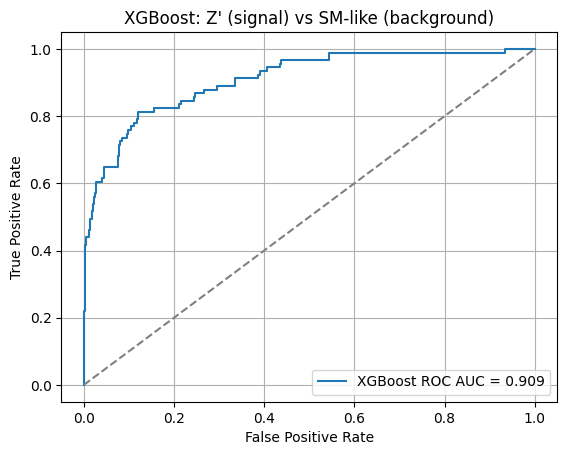

0.9085151937264613

In [165]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict signal probability
y_score = xgb.predict_proba(X_test_f)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost ROC AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost: Z' (signal) vs SM-like (background)")
plt.legend()
plt.grid(True)
plt.show()

auc

m_ll               0.152605
n_sig_lep          0.096646
st                 0.095221
lead_jet_pt        0.064088
jet_n              0.061644
lead_lep_pt        0.056141
dphi_ll            0.055610
lead_jet_btag      0.036535
lt                 0.036519
sublead_lep_pt     0.032902
met                0.029997
lead_lep_eta       0.027195
sublead_jet_phi    0.025497
sublead_lep_phi    0.023336
lead_jet_eta       0.021813
dtype: float32

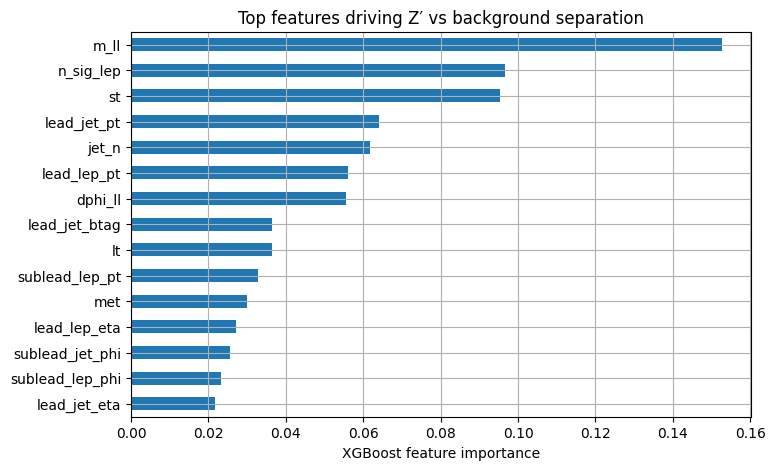

In [166]:
# Quick interpretability: feature importance from the trained XGBoost model
import pandas as pd
import matplotlib.pyplot as plt

fi = pd.Series(xgb.feature_importances_, index=X_train_f.columns).sort_values(ascending=False)
display(fi.head(15))

plt.figure(figsize=(8, 5))
fi.head(15).sort_values().plot(kind="barh")
plt.xlabel("XGBoost feature importance")
plt.title("Top features driving Z′ vs background separation")
plt.grid(True)
plt.show()

In [167]:
# Phase 4: "Bump hunt" — reconstruct an approximate invariant mass
# NOTE: We approximate neutrinos with MET in transverse plane (pz=0).

import numpy as np

def p4_massless(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E  = pt * np.cosh(eta)
    return E, px, py, pz

def system_mass_2j2l_met(jet_pt, jet_eta, jet_phi, lep_pt, lep_eta, lep_phi, met, met_phi):
    # Use leading 2 jets + leading 2 leptons + MET as a massless 4-vector with pz=0
    jet_pt2  = ak.pad_none(jet_pt, 2)
    jet_eta2 = ak.pad_none(jet_eta, 2)
    jet_phi2 = ak.pad_none(jet_phi, 2)
    lep_pt2  = ak.pad_none(lep_pt, 2)
    lep_eta2 = ak.pad_none(lep_eta, 2)
    lep_phi2 = ak.pad_none(lep_phi, 2)

    j1_pt  = np.array(ak.fill_none(jet_pt2[:, 0], 0))
    j1_eta = np.array(ak.fill_none(jet_eta2[:, 0], 0))
    j1_phi = np.array(ak.fill_none(jet_phi2[:, 0], 0))
    j2_pt  = np.array(ak.fill_none(jet_pt2[:, 1], 0))
    j2_eta = np.array(ak.fill_none(jet_eta2[:, 1], 0))
    j2_phi = np.array(ak.fill_none(jet_phi2[:, 1], 0))

    l1_pt  = np.array(ak.fill_none(lep_pt2[:, 0], 0))
    l1_eta = np.array(ak.fill_none(lep_eta2[:, 0], 0))
    l1_phi = np.array(ak.fill_none(lep_phi2[:, 0], 0))
    l2_pt  = np.array(ak.fill_none(lep_pt2[:, 1], 0))
    l2_eta = np.array(ak.fill_none(lep_eta2[:, 1], 0))
    l2_phi = np.array(ak.fill_none(lep_phi2[:, 1], 0))

    E1, px1, py1, pz1 = p4_massless(j1_pt, j1_eta, j1_phi)
    E2, px2, py2, pz2 = p4_massless(j2_pt, j2_eta, j2_phi)
    E3, px3, py3, pz3 = p4_massless(l1_pt, l1_eta, l1_phi)
    E4, px4, py4, pz4 = p4_massless(l2_pt, l2_eta, l2_phi)

    met = np.array(met)
    met_phi = np.array(met_phi)
    Em  = met
    pxm = met * np.cos(met_phi)
    pym = met * np.sin(met_phi)
    pzm = np.zeros_like(met)

    E  = E1 + E2 + E3 + E4 + Em
    px = px1 + px2 + px3 + px4 + pxm
    py = py1 + py2 + py3 + py4 + pym
    pz = pz1 + pz2 + pz3 + pz4 + pzm

    m2 = E*E - (px*px + py*py + pz*pz)
    return np.sqrt(np.maximum(m2, 0.0))

# Mass for signal + background in same row order as X_all = concat([X_event, X_bg])
m_sig_all = system_mass_2j2l_met(jets["jet_pt"], jets["jet_eta"], jets["jet_phi"], leps["lep_pt"], leps["lep_eta"], leps["lep_phi"], X_event["met"], X_event["met_phi"])
m_bkg_all = system_mass_2j2l_met(bg_jets["jet_pt"], bg_jets["jet_eta"], bg_jets["jet_phi"], bg_leps["lep_pt"], bg_leps["lep_eta"], bg_leps["lep_phi"], X_bg["met"], X_bg["met_phi"])
m_all = np.concatenate([m_sig_all, m_bkg_all])

m_all[:5], m_all.shape

(array([1017.59745327,  931.05277631,  843.7765125 , 1707.31372116,
        1596.43586761]),
 (3769,))

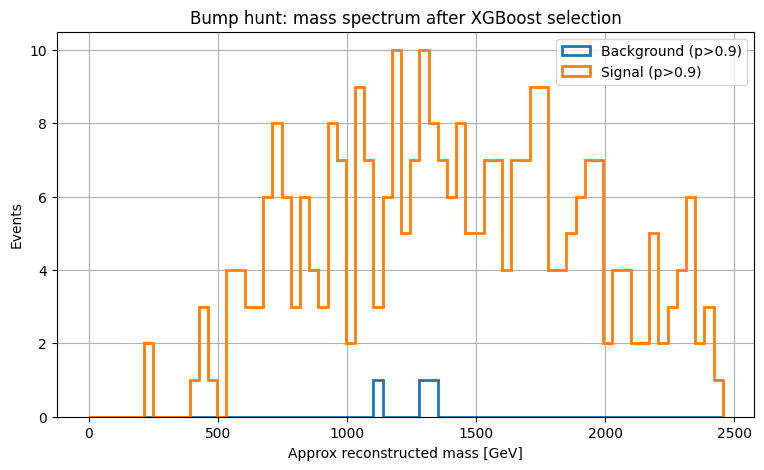

(302, 3)

In [168]:
# Apply the trained model to ALL events, then plot mass for signal-like selections
import numpy as np
import matplotlib.pyplot as plt

X_all_f = X_all.replace([np.inf, -np.inf], np.nan).fillna(0)
proba_all = xgb.predict_proba(X_all_f)[:, 1]

# Selection: model thinks "signal"
sel = proba_all > 0.90

m_sig_sel = m_all[sel & (y_all == 1)]
m_bkg_sel = m_all[sel & (y_all == 0)]

plt.figure(figsize=(9, 5))
bins = np.linspace(0, np.percentile(m_all, 99.5), 70)
plt.hist(m_bkg_sel, bins=bins, histtype="step", linewidth=2, label="Background (p>0.9)")
plt.hist(m_sig_sel, bins=bins, histtype="step", linewidth=2, label="Signal (p>0.9)")
plt.xlabel("Approx reconstructed mass [GeV]")
plt.ylabel("Events")
plt.title("Bump hunt: mass spectrum after XGBoost selection")
plt.grid(True)
plt.legend()
plt.show()

len(m_sig_sel), len(m_bkg_sel)

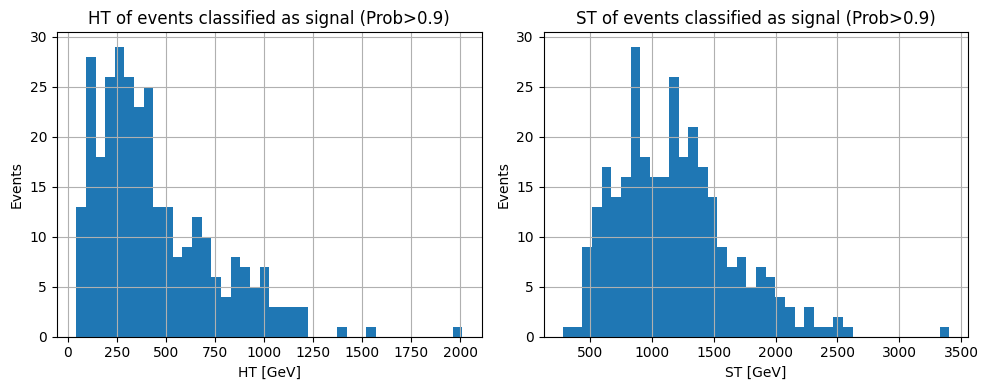

In [169]:
# Extra validation plot: HT and ST for events classified as signal-like
import matplotlib.pyplot as plt

sel_df = X_all.loc[sel].copy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(sel_df["ht"], bins=40)
plt.title("HT of events classified as signal (Prob>0.9)")
plt.xlabel("HT [GeV]")
plt.ylabel("Events")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(sel_df["st"], bins=40)
plt.title("ST of events classified as signal (Prob>0.9)")
plt.xlabel("ST [GeV]")
plt.ylabel("Events")
plt.grid(True)

plt.tight_layout()
plt.show()